<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Seyed Mohammad Eshtehardian'
std_id = '402200948'

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 902kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 56.8kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.33MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [10]:
import torch.nn as nn

latent_dim = 100
ngf = 64
ndf = 64

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 1, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1, 1).squeeze(1)

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

lr = 0.0002
batch_size = 64
num_epochs = 40
n_critic = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

generator = Generator(latent_dim).to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = nn.BCELoss()

def train_gan(generator, discriminator, dataloader, num_epochs, latent_dim, n_critic):
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        for i, (imgs, _) in enumerate(dataloader):

            valid = torch.ones(imgs.size(0)).to(device)
            fake = torch.zeros(imgs.size(0)).to(device)
            real_imgs = imgs.cuda()

            # discriminator training
            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim, 1, 1, device=device)
            gen_imgs = generator(z)
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # generator training
            if i % n_critic == 0:
                optimizer_G.zero_grad()
                gen_imgs = generator(z)
                g_loss = adversarial_loss(discriminator(gen_imgs), valid)
                g_loss.backward()
                optimizer_G.step()

        if epoch % 5 == 0:
          try:
            os.makedirs("models")
          except FileExistsError:
            pass
          checkpoint_path = os.path.join("models", f'model_iter_{epoch+1}.pth')
          torch.save({
              'epoch': epoch + 1,
              'discriminator_state_dict': discriminator.state_dict(),
              'generator_state_dict': generator.state_dict(),
          }, checkpoint_path)
          save_samples(generator, epoch, latent_dim)

        print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")


    try:
      os.makedirs("models")
    except FileExistsError:
      pass
    checkpoint_path = os.path.join("models", f'model_final.pth')
    torch.save({
        'epoch': 'final',
        'discriminator_state_dict': discriminator.state_dict(),
        'generator_state_dict': generator.state_dict(),
    }, checkpoint_path)

def save_samples(generator, epoch, latent_dim, n=100):
    z = torch.randn(n, latent_dim, 1, 1, device=device)
    gen_imgs = generator(z)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    gen_imgs = gen_imgs.detach().cpu().numpy()

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(gen_imgs[i*10 + j, 0], cmap='gray')
            axes[i, j].axis('off')
    try:
      os.makedirs("samples")
    except FileExistsError:
      pass

    plt.savefig(f'samples/epoch_{epoch}.png')
    plt.close()

train_gan(generator, discriminator, train_loader, num_epochs, latent_dim, n_critic)

cuda


Epoch:   2%|▎         | 1/40 [00:38<24:44, 38.05s/it]

[Epoch 0/40] [D loss: 0.002773] [G loss: 8.173868]


Epoch:   5%|▌         | 2/40 [01:15<23:51, 37.66s/it]

[Epoch 1/40] [D loss: 0.005990] [G loss: 8.511309]


Epoch:   8%|▊         | 3/40 [01:50<22:33, 36.58s/it]

[Epoch 2/40] [D loss: 0.000767] [G loss: 8.109506]


Epoch:  10%|█         | 4/40 [02:25<21:35, 35.99s/it]

[Epoch 3/40] [D loss: 0.004889] [G loss: 7.968202]


Epoch:  12%|█▎        | 5/40 [03:04<21:28, 36.82s/it]

[Epoch 4/40] [D loss: 0.025937] [G loss: 10.938269]


Epoch:  15%|█▌        | 6/40 [03:41<20:59, 37.05s/it]

[Epoch 5/40] [D loss: 0.018430] [G loss: 5.647760]


Epoch:  18%|█▊        | 7/40 [04:16<19:59, 36.34s/it]

[Epoch 6/40] [D loss: 0.003659] [G loss: 6.444807]


Epoch:  20%|██        | 8/40 [04:52<19:17, 36.18s/it]

[Epoch 7/40] [D loss: 0.025427] [G loss: 6.857083]


Epoch:  22%|██▎       | 9/40 [05:27<18:27, 35.71s/it]

[Epoch 8/40] [D loss: 0.065829] [G loss: 4.540583]


Epoch:  25%|██▌       | 10/40 [06:01<17:42, 35.41s/it]

[Epoch 9/40] [D loss: 0.038549] [G loss: 4.055717]


Epoch:  28%|██▊       | 11/40 [06:38<17:18, 35.80s/it]

[Epoch 10/40] [D loss: 0.550018] [G loss: 2.611948]


Epoch:  30%|███       | 12/40 [07:14<16:45, 35.91s/it]

[Epoch 11/40] [D loss: 0.083408] [G loss: 2.910706]


Epoch:  32%|███▎      | 13/40 [07:50<16:07, 35.82s/it]

[Epoch 12/40] [D loss: 0.039395] [G loss: 4.603278]


Epoch:  35%|███▌      | 14/40 [08:30<16:05, 37.12s/it]

[Epoch 13/40] [D loss: 0.159239] [G loss: 4.502428]


Epoch:  38%|███▊      | 15/40 [09:07<15:27, 37.10s/it]

[Epoch 14/40] [D loss: 1.272065] [G loss: 4.151919]


Epoch:  40%|████      | 16/40 [09:44<14:53, 37.23s/it]

[Epoch 15/40] [D loss: 0.027972] [G loss: 4.973816]


Epoch:  42%|████▎     | 17/40 [10:22<14:20, 37.41s/it]

[Epoch 16/40] [D loss: 0.215713] [G loss: 2.353466]


Epoch:  45%|████▌     | 18/40 [10:58<13:29, 36.81s/it]

[Epoch 17/40] [D loss: 0.139189] [G loss: 3.554958]


Epoch:  48%|████▊     | 19/40 [11:34<12:52, 36.77s/it]

[Epoch 18/40] [D loss: 0.046053] [G loss: 3.538564]


Epoch:  50%|█████     | 20/40 [12:12<12:21, 37.10s/it]

[Epoch 19/40] [D loss: 0.088308] [G loss: 2.543992]


Epoch:  52%|█████▎    | 21/40 [12:53<12:08, 38.35s/it]

[Epoch 20/40] [D loss: 0.058009] [G loss: 3.843925]


Epoch:  55%|█████▌    | 22/40 [13:30<11:20, 37.82s/it]

[Epoch 21/40] [D loss: 0.106116] [G loss: 2.909752]


Epoch:  57%|█████▊    | 23/40 [14:06<10:31, 37.16s/it]

[Epoch 22/40] [D loss: 0.542155] [G loss: 4.054972]


Epoch:  60%|██████    | 24/40 [14:41<09:45, 36.62s/it]

[Epoch 23/40] [D loss: 0.028804] [G loss: 1.986231]


Epoch:  62%|██████▎   | 25/40 [15:17<09:04, 36.30s/it]

[Epoch 24/40] [D loss: 0.202545] [G loss: 2.979182]


Epoch:  65%|██████▌   | 26/40 [15:53<08:29, 36.36s/it]

[Epoch 25/40] [D loss: 0.188201] [G loss: 4.327564]


Epoch:  68%|██████▊   | 27/40 [16:28<07:47, 35.95s/it]

[Epoch 26/40] [D loss: 0.173574] [G loss: 3.213093]


Epoch:  70%|███████   | 28/40 [17:03<07:07, 35.62s/it]

[Epoch 27/40] [D loss: 0.296855] [G loss: 1.147036]


Epoch:  72%|███████▎  | 29/40 [17:38<06:28, 35.35s/it]

[Epoch 28/40] [D loss: 0.313611] [G loss: 2.323967]


Epoch:  75%|███████▌  | 30/40 [18:12<05:51, 35.11s/it]

[Epoch 29/40] [D loss: 0.126071] [G loss: 2.365321]


Epoch:  78%|███████▊  | 31/40 [18:51<05:24, 36.08s/it]

[Epoch 30/40] [D loss: 0.239655] [G loss: 1.743057]


Epoch:  80%|████████  | 32/40 [19:26<04:46, 35.76s/it]

[Epoch 31/40] [D loss: 0.313585] [G loss: 2.090485]


Epoch:  82%|████████▎ | 33/40 [20:05<04:18, 36.96s/it]

[Epoch 32/40] [D loss: 0.151497] [G loss: 4.214864]


Epoch:  85%|████████▌ | 34/40 [20:42<03:41, 36.84s/it]

[Epoch 33/40] [D loss: 0.200180] [G loss: 2.969379]


Epoch:  88%|████████▊ | 35/40 [21:18<03:02, 36.57s/it]

[Epoch 34/40] [D loss: 0.266520] [G loss: 3.309399]


Epoch:  90%|█████████ | 36/40 [21:54<02:26, 36.57s/it]

[Epoch 35/40] [D loss: 0.411140] [G loss: 2.789357]


Epoch:  92%|█████████▎| 37/40 [22:31<01:49, 36.59s/it]

[Epoch 36/40] [D loss: 0.336695] [G loss: 2.039522]


Epoch:  95%|█████████▌| 38/40 [23:10<01:14, 37.22s/it]

[Epoch 37/40] [D loss: 0.231406] [G loss: 4.906039]


Epoch:  98%|█████████▊| 39/40 [23:46<00:36, 36.97s/it]

[Epoch 38/40] [D loss: 0.119039] [G loss: 2.851280]


Epoch: 100%|██████████| 40/40 [24:22<00:00, 36.56s/it]

[Epoch 39/40] [D loss: 0.546038] [G loss: 1.429152]


### Part 4: Plot a grid of 100 generated samples.

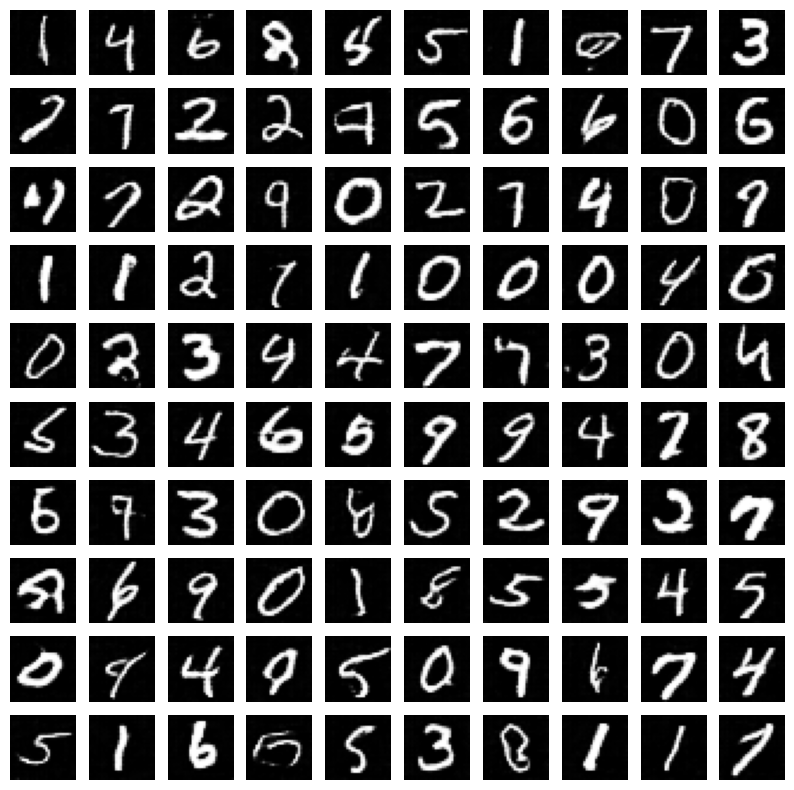

In [13]:
z = torch.randn(100, latent_dim, 1, 1, device=device)
gen_imgs = generator(z)
gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
gen_imgs = gen_imgs.detach().cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axes[i, j].imshow(gen_imgs[i*10 + j, 0], cmap='gray')
        axes[i, j].axis('off')
plt.show()

### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


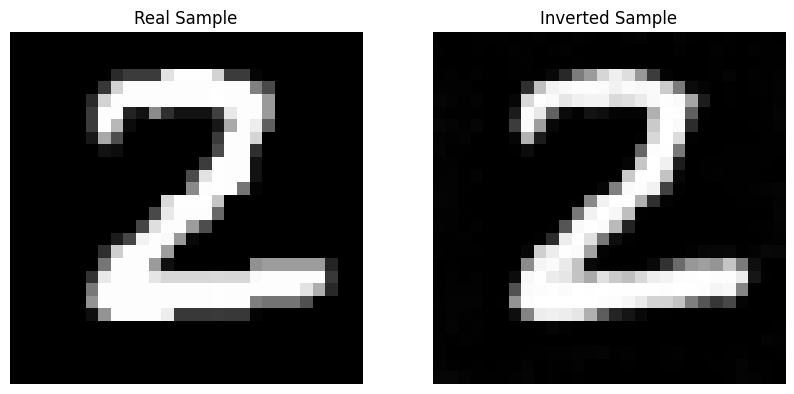

In [17]:
def gan_inversion(generator, real_sample, latent_dim, num_steps=1000, lr=0.1):
    z = torch.randn(1, latent_dim, 1, 1, requires_grad=True, device=device)
    optimizer = optim.Adam([z], lr=lr)
    mse_loss = nn.MSELoss()

    for step in range(num_steps):
        optimizer.zero_grad()
        gen_sample = generator(z)
        loss = mse_loss(gen_sample, real_sample)
        loss.backward()
        optimizer.step()

    return z

real_sample = None

for img, _ in train_loader:
  real_sample = img[0][0].view(1, 1, 28, 28).cuda()
  break

latent_vector = gan_inversion(generator, real_sample, latent_dim)

inverted_sample = generator(latent_vector)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(real_sample.view(28, 28).detach().cpu().numpy(), cmap='gray')
axes[0].set_title('Real Sample')
axes[0].axis('off')

axes[1].imshow(inverted_sample.view(28, 28).detach().cpu().numpy(), cmap='gray')
axes[1].set_title('Inverted Sample')
axes[1].axis('off')

plt.show()

### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

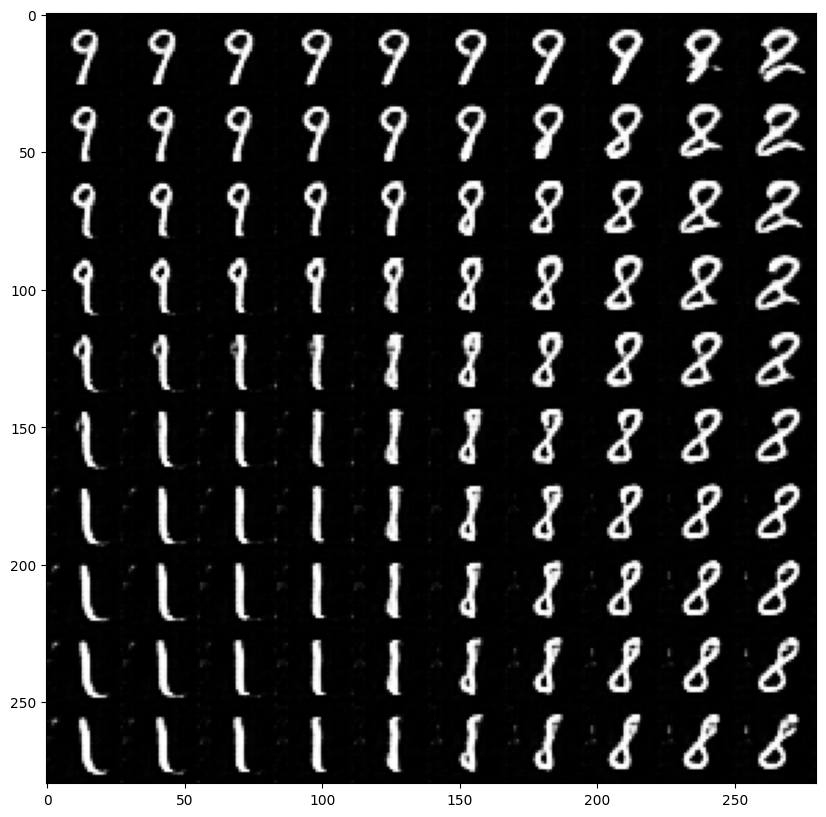

In [21]:
import numpy as np

def interpolate_latent_space(generator, z1, z2, z3, z4, n=10, digit_size=28):
    alphas = torch.linspace(0, np.pi/2, n)
    betas = torch.linspace(0, np.pi/2, n)
    manifold = np.zeros((n*digit_size, n*digit_size))

    for i, alpha in enumerate(alphas):
      for j, beta in enumerate(betas):
        x, y = (i % n) * digit_size, (j % n) * digit_size
        z = np.cos(alpha)*(np.cos(beta)*z1+np.sin(beta)*z2) + np.sin(alpha)*(np.cos(beta)*z3+np.sin(beta)*z4)
        interpolated_image = generator(z).detach().cpu().numpy()
        manifold[x:x+digit_size, y:y+digit_size] = interpolated_image.copy()

    return manifold

z1 = torch.randn(1, latent_dim, 1, 1, device=device)
z2 = torch.randn(1, latent_dim, 1, 1, device=device)
z3 = torch.randn(1, latent_dim, 1, 1, device=device)
z4 = torch.randn(1, latent_dim, 1, 1, device=device)

plt.figure(figsize=(10, 10))
manifold = interpolate_latent_space(generator, z1, z2, z3, z4)
plt.imshow(manifold, cmap='gray')
plt.show()

### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


#### Change Thikness

First we have to find the direction for the thikness. From the figures below this direction should be between the 0'th element and 34'th element.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


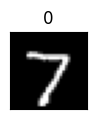

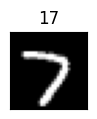

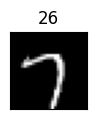

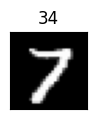

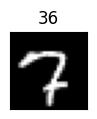

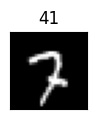

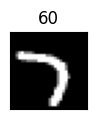

In [49]:
for imgs, labels in test_loader:
  target = labels[0]
  plt.figure(figsize=(1, 1))
  plt.title(0)
  plt.imshow(imgs[0].numpy().reshape(28, 28), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  for i in range(1, len(labels)):
    if labels[i] == target:
      plt.figure(figsize=(1, 1))
      plt.title(i)
      plt.imshow(imgs[i].numpy().reshape(28, 28), cmap='gray')
      plt.xticks([])
      plt.yticks([])
  break

z1, z2 = None, None

for imgs, labels in test_loader:
  z1 = gan_inversion(generator, imgs[0].cuda(), latent_dim)
  z2 = gan_inversion(generator, imgs[34].cuda(), latent_dim)
  break

Now we can change the thikness by moving in that direction.

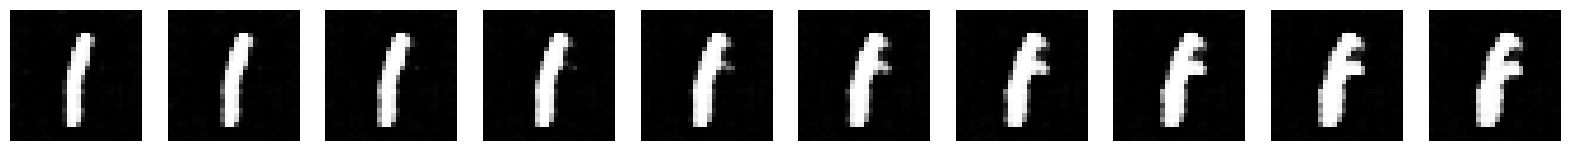

In [59]:
def latent_arithmetic_thickness(generator, z_main, z1, z2, steps=10):
    alphas = torch.linspace(0, 0.5, steps)
    modified_images = []

    for alpha in alphas:
        z = z_main + alpha * (z2 - z1)
        modified_image = generator(z)
        modified_images.append(modified_image)

    return torch.stack(modified_images)

z_main = None

for img, _ in train_loader:
  z_main = gan_inversion(generator, img[0].cuda(), latent_dim)
  break

modified_images = latent_arithmetic_thickness(generator, z_main, z1, z2)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(modified_images[i].view(28, 28).detach().cpu().numpy(), cmap='gray')
    axes[i].axis('off')

plt.show()

#### Change Numbers to 3

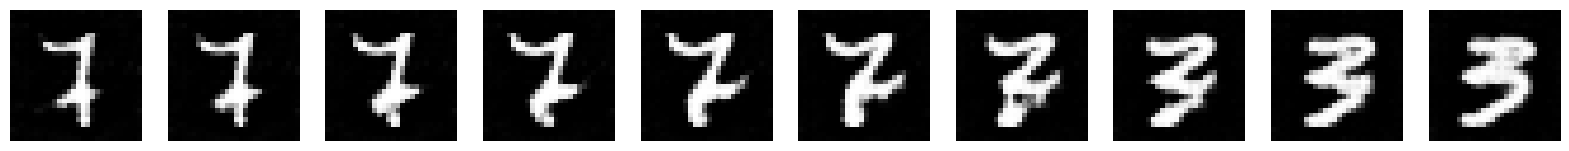

In [40]:
def latent_arithmetic(generator, z1, z2, steps=10):
    alphas = torch.linspace(0, 1, steps)
    modified_images = []

    for alpha in alphas:
        z = z1 + alpha * (z2 - z1)
        modified_image = generator(z)
        modified_images.append(modified_image)

    return torch.stack(modified_images)

z1, z2 = None, None
for imgs, labels in train_loader:
  if z1 is not None and z2 is not None:
      break
  for i in range(len(labels)):
    img = imgs[i].cuda()
    label = labels[i]
    if z1 is not None and z2 is not None:
      break
    if label != 3 and z1 is None:
      z1 = gan_inversion(generator, img, latent_dim)
    if label == 3 and z2 is None:
      z2 = gan_inversion(generator, img, latent_dim)

modified_images = latent_arithmetic(generator, z1, z2)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(modified_images[i].view(28, 28).detach().cpu().numpy(), cmap='gray')
    axes[i].axis('off')

plt.show()